In [106]:
import os
import glob as glob
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist,squareform
import os
from nltools.mask import expand_mask, roi_to_brain
from nltools.data import Brain_Data, Adjacency
from tqdm.notebook import tqdm

In [5]:
base_dir = '/Volumes/Shaolin/modernmedia_menghan/'
behavior = ['3_ResearchDataSet','4_Prestudy Survey Data']
behavior_file = glob.glob(os.path.join(base_dir,behavior[0],'*.csv'))
behavior_file

['/Volumes/Shaolin/modernmedia_menghan/3_ResearchDataSet/kamm_data_2023-11-01_1026.csv']

In [18]:
behavior_all = pd.read_csv(behavior_file[0])
behavior_all

,record_id,scrn_id,kammstudyid,visit_date,mri_sid_number,stimuli_condition,childsex,child_age_visit,studystatus,pmu,...,pmu_self_5,pmu_self_6,pmu_self_7,pmu_self_8,pmu_self_9,pmu_self_10,pmu_self_11,child_ave_ht_1,child_ave_wt_1,baseline_satiety_1
0,1,1428a,KA0023,5/30/2023,SID002615,1,1,11.87,3,2.670,...,3.0,3.0,1.0,1.0,1.0,2.0,1.0,146.20,43.15,132.0
1,2,1422a,KA0043,6/9/2023,SID002528,3,1,12.91,3,4.110,...,2.0,3.0,1.0,2.0,2.0,2.0,1.0,166.90,52.70,72.0
2,3,1225b,KA0018,5/8/2023,SID002138,5,0,11.95,3,2.670,...,2.0,3.0,1.0,1.0,2.0,2.0,2.0,166.47,84.23,120.0
3,4,495b,KA0088,5/13/2023,SID002700,1,0,9.35,3,2.220,...,3.0,4.0,1.0,2.0,3.0,3.0,2.0,125.20,30.60,NaN
4,5,1437a,KA0012,5/13/2023,SID002701,3,0,9.57,3,2.670,...,1.0,1.0,1.0,1.0,2.0,3.0,1.0,134.97,31.65,NaN
5,6,1175B,KA0090,6/2/2023,SID001962,4,0,11.24,3,3.220,...,4.0,2.0,1.0,3.0,2.0,2.0,3.0,158.53,67.78,85.0
6,7,33a,KA0058,6/26/2023,SID002279,5,0,9.99,3,1.440,...,1.0,2.0,1.0,1.0,1.0,1.0,1.0,141.93,40.90,86.0
7,8,696A,KA0093,5/20/2023,SID002074,2,0,11.43,3,3.220,...,4.0,5.0,1.0,2.0,3.0,4.0,3.0,154.17,43.03,104.0
8,10,36B,KA0006,5/4/2023,SID002681,4,0,10.51,3,1.560,...,3.0,1.0,1.0,1.0,1.0,1.0,1.0,140.87,30.73,112.0
9,11,1335b,KA0053,5/19/2023,SID002307,3,1,10.08,3,2.780,...,2.0,3.0,1.0,1.0,1.0,2.0,2.0,141.43,31.55,82.0


In [14]:
cmp_cols = [col for col in behavior_all.columns if 'cmp' in col]
print(cmp_cols) 

['cmp_schoolyear', 'cmp_tvtime', 'cmp_comptime', 'cmp_tablettime', 'cmp_sphonetime', 'cmp_vgametime', 'cmp_tvtime_sat', 'cmp_comptime_sat', 'cmp_tablettime_sat', 'cmp_sphonetime_sat', 'cmp_vgametime_sat', 'cmp_tv_freq', 'cmp_tv_time', 'cmp_dvd_freq', 'cmp_dvd_time', 'cmp_youtik_freq', 'cmp_youtik_time', 'cmp_insta_freq', 'cmp_insta_time', 'cmp_discord_freq', 'cmp_discord_time', 'cmp_mine_freq', 'cmp_mine_time', 'cmp_text_freq', 'cmp_text_time']


## Participants that have both neural and behavioral data

In [47]:
condition = ['Household','MobileDevice','MediaLogo','Food','NeutralLogo']
group_file_list = glob.glob(os.path.join(base_dir,'denoised','smoothed','beta',f'sub*{condition[0]}*.nii.gz'))
sub_name_all_neural = []
for i in group_file_list:
    a = i.split('/')[-1]
    m = a.split('_')[0]
    sub_name_all_neural.append(m)
len(sub_name_all_neural)

SID_list_neural = []
for SID in sub_name_all_neural:
    # print(SID)
    SID_list_neural.append(SID[-6:])

In [48]:
sub_name_all_behavior = behavior_all['mri_sid_number'].values.tolist()
SID_list_behavior = []
for SID in sub_name_all_behavior:
    # print(SID)
    SID_list_behavior.append(SID[-6:])

TypeError: 'float' object is not subscriptable

In [49]:
sub_name_all = [item for item in SID_list_behavior if item in SID_list_neural]
print(len(sub_name_all))

34


### Behavioral similarity

In [60]:
sub_name_all_behavior_similarity = ['SID' + item for item in sub_name_all]
sub_name_all_neural_similarity = ['sub-sid' + item for item in sub_name_all]

#### cmp

In [77]:
partitipants_behavior_df = behavior_all[behavior_all['mri_sid_number'].isin(sub_name_all_behavior_similarity)]
partitipants_behavior_df_cmp = partitipants_behavior_df[cmp_cols]

[Text(0.5, 1.0, 'cmp similarity')]

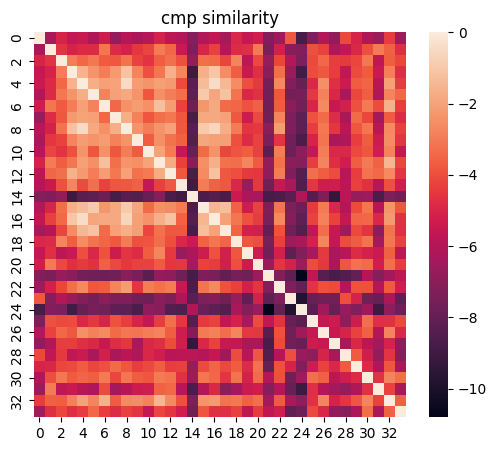

In [85]:
cmp_distance = Adjacency(squareform(pdist(partitipants_behavior_df_cmp, metric = 'euclidean')), matrix_type="distance")
cmp_similarity = Adjacency.distance_to_similarity(cmp_distance)
cmp_similarity = cmp_similarity.squareform()
sub_fig, _ = plt.subplots(figsize=(6,5))
sns.heatmap(cmp_similarity).set(title = 'cmp similarity' )


[Text(0.5, 1.0, 'cmp distance')]

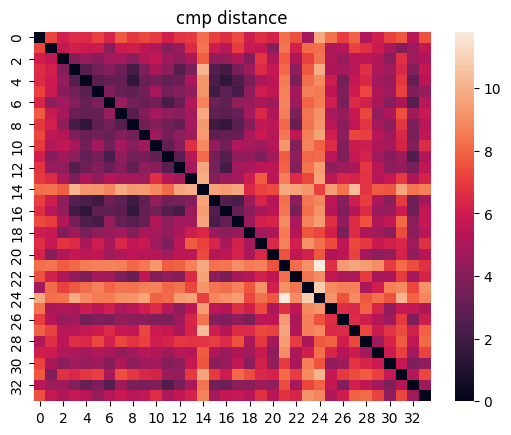

In [101]:
cmp_distance = cmp_distance.squareform()
sns.heatmap(cmp_distance).set(title = 'cmp distance' )

#### cmk

In [116]:
cmk_cols = [col for col in behavior_all.columns if 'cmk' in col]
print(cmk_cols) 

['cmk_tv_freq', 'cmk_tv_time', 'cmk_dvd_freq', 'cmk_dvd_time', 'cmk_youtik_freq', 'cmk_youtik_time', 'cmk_insta_freq', 'cmk_insta_time', 'cmk_discord_freq', 'cmk_discord_time', 'cmk_mine_freq', 'cmk_mine_time', 'cmk_text_freq', 'cmk_text_time', 'cmk_like_youtube', 'cmk_like_tik', 'cmk_like_insta', 'cmk_like_snap', 'cmk_like_discord', 'cmk_like_roblox', 'cmk_like_mine', 'cmk_like_messenger', 'cmk_like_messenger_2']


[Text(0.5, 1.0, 'cmk similarity')]

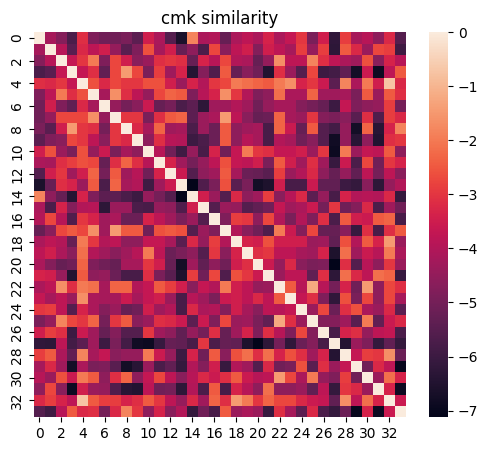

In [119]:
partitipants_behavior_df_cmk = partitipants_behavior_df[cmk_cols]
partitipants_behavior_df_cmk = partitipants_behavior_df_cmk.dropna(axis=1,how='any') ## Nan data
cmk_distance = Adjacency(squareform(pdist(partitipants_behavior_df_cmk, metric = 'euclidean')), matrix_type="distance")
cmk_similarity = Adjacency.distance_to_similarity(cmk_distance)
cmk_similarity = cmk_similarity.squareform()
sub_fig, _ = plt.subplots(figsize=(6,5))
sns.heatmap(cmk_similarity).set(title = 'cmk similarity' )


[Text(0.5, 1.0, 'cmk distance')]

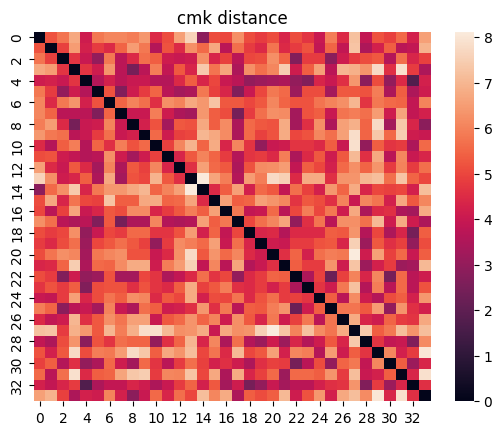

In [120]:
cmk_distance = cmk_distance.squareform()
sns.heatmap(cmk_distance).set(title = 'cmk distance' )

## similarity between neural distance and behavioral distance

nltools.data.brain_data.Brain_Data(data=(50, 238955), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz)

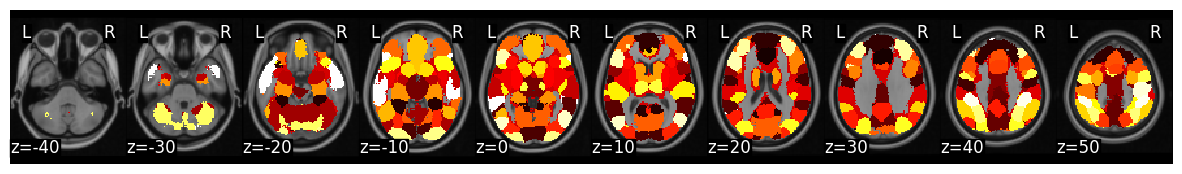

In [90]:
mask = Brain_Data('http://neurovault.org/media/images/2099/Neurosynth%20Parcellation_0.nii.gz')
mask.plot()
#expand this mask into 50 separate regions
mask_x = expand_mask(mask) 
mask_x

#### Brain data: Media activation; Behavioral data: cmp (parent_survey_child_media_use)

In [88]:
partitipants_neural_all = Brain_Data()
for subject in sub_name_all_neural_similarity:
    partitipants_neural_all = partitipants_neural_all.append(Brain_Data(glob.glob(os.path.join(base_dir,'denoised','unsmoothed','beta',f'{subject}*{condition[2]}*.nii.gz'))))

In [107]:
ROI_corr = []
for ROI in tqdm(range(50)):
    neural_corr = pd.DataFrame(partitipants_neural_all.apply_mask(mask_x[ROI]).data).T.corr()
    neural_corr = np.array(neural_corr)
    neural_corr_trail = neural_corr[np.triu_indices(34, 1)]
    neural_distance = 1-neural_corr_trail

    cmp_distance_trail = cmp_distance[np.triu_indices(34, 1)]

    data_pd = pd.DataFrame(np.array([neural_distance,cmp_distance_trail]).T,columns = ['neural','behavior'])
    results_corr = data_pd.corr(method = 'spearman').iloc[0,1]
    ROI_corr.append(results_corr)

  0%|          | 0/50 [00:00<?, ?it/s]

/Users/menghanyang/anaconda3/envs/py39/lib/python3.9/site-packages/nilearn/masking.py:974: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)
/Users/menghanyang/anaconda3/envs/py39/lib/python3.9/site-packages/nilearn/masking.py:974: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)
/Users/menghanyang/anaconda3/envs/py39/lib/python3.9/site-packages/nilearn/masking.py:974: UserWarning: Data array used to create a new imag

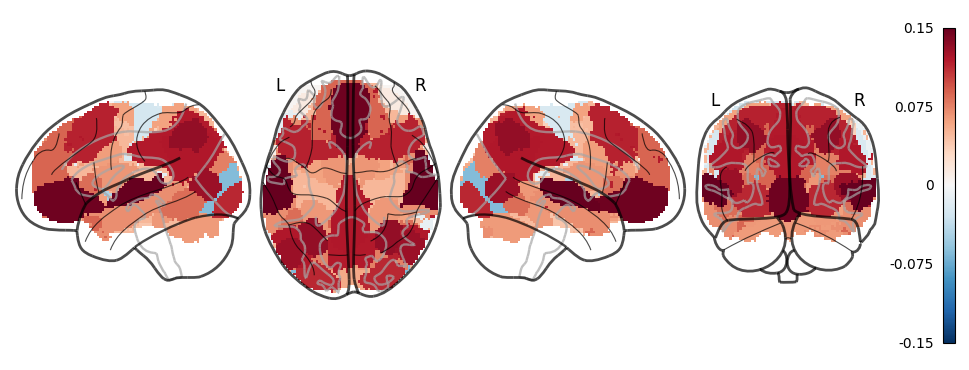

In [108]:
from nilearn.plotting import plot_glass_brain

ROI_corr_cmp_brain = roi_to_brain(ROI_corr, mask_x)

# plot_glass_brain(ROI_corr_cmp_brain.to_nifti(), display_mode='xz',colorbar=True,cmap='RdBu_r',plot_abs=False)
plot_glass_brain(ROI_corr_cmp_brain.to_nifti(), display_mode='lzry',colorbar=True,cmap='RdBu_r',plot_abs=False)


#### Brain data: Media-Neutral activation; Behavioral data: cmp (parent_survey_child_media_use)

In [112]:
partitipants_neural_all = Brain_Data()
for subject in sub_name_all_neural_similarity:
    partitipants_neural_all = partitipants_neural_all.append(Brain_Data(glob.glob(os.path.join(base_dir,'denoised','unsmoothed','beta',f'{subject}*{condition[2]}*.nii.gz')))-Brain_Data(glob.glob(os.path.join(base_dir,'denoised','unsmoothed','beta',f'{subject}*{condition[4]}*.nii.gz'))))

In [113]:
ROI_corr = []
for ROI in tqdm(range(50)):
    neural_corr = pd.DataFrame(partitipants_neural_all.apply_mask(mask_x[ROI]).data).T.corr()
    neural_corr = np.array(neural_corr)
    neural_corr_trail = neural_corr[np.triu_indices(34, 1)]
    neural_distance = 1-neural_corr_trail

    cmp_distance_trail = cmp_distance[np.triu_indices(34, 1)]

    data_pd = pd.DataFrame(np.array([neural_distance,cmp_distance_trail]).T,columns = ['neural','behavior'])
    results_corr = data_pd.corr(method = 'spearman').iloc[0,1]
    ROI_corr.append(results_corr)

  0%|          | 0/50 [00:00<?, ?it/s]

/Users/menghanyang/anaconda3/envs/py39/lib/python3.9/site-packages/nilearn/masking.py:974: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)
/Users/menghanyang/anaconda3/envs/py39/lib/python3.9/site-packages/nilearn/masking.py:974: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)
/Users/menghanyang/anaconda3/envs/py39/lib/python3.9/site-packages/nilearn/masking.py:974: UserWarning: Data array used to create a new imag

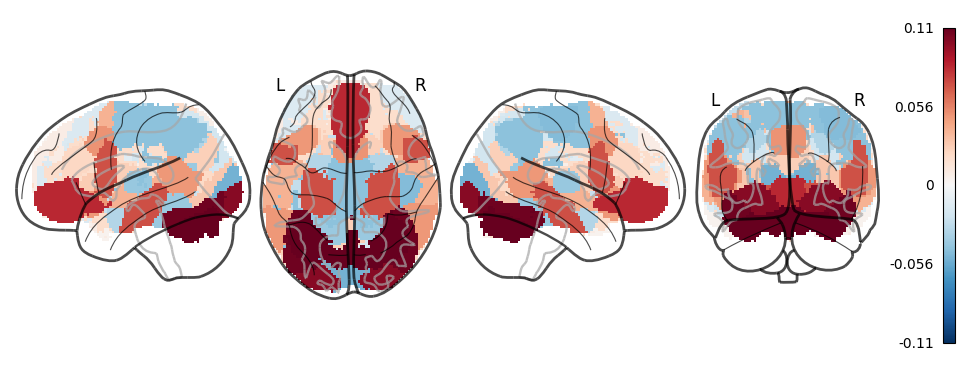

In [114]:
from nilearn.plotting import plot_glass_brain

ROI_corr_cmp_brain = roi_to_brain(ROI_corr, mask_x)
plot_glass_brain(ROI_corr_cmp_brain.to_nifti(), display_mode='lzry',colorbar=True,cmap='RdBu_r',plot_abs=False)


#### Brain data: Media; Behavioral data: cmk (postscan_child_survey)

In [129]:
partitipants_neural_all = Brain_Data()
for subject in sub_name_all_neural_similarity:
    partitipants_neural_all = partitipants_neural_all.append(Brain_Data(glob.glob(os.path.join(base_dir,'denoised','unsmoothed','beta',f'{subject}*{condition[2]}*.nii.gz'))))

In [130]:
ROI_corr = []
for ROI in tqdm(range(50)):
    neural_corr = pd.DataFrame(partitipants_neural_all.apply_mask(mask_x[ROI]).data).T.corr()
    neural_corr = np.array(neural_corr)
    neural_corr_trail = neural_corr[np.triu_indices(34, 1)]
    neural_distance = 1-neural_corr_trail

    cmk_distance_trail = cmk_distance[np.triu_indices(34, 1)]

    data_pd = pd.DataFrame(np.array([neural_distance,cmk_distance_trail]).T,columns = ['neural','behavior'])
    results_corr = data_pd.corr(method = 'spearman').iloc[0,1]
    ROI_corr.append(results_corr)

  0%|          | 0/50 [00:00<?, ?it/s]

/Users/menghanyang/anaconda3/envs/py39/lib/python3.9/site-packages/nilearn/masking.py:974: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)
/Users/menghanyang/anaconda3/envs/py39/lib/python3.9/site-packages/nilearn/masking.py:974: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)
/Users/menghanyang/anaconda3/envs/py39/lib/python3.9/site-packages/nilearn/masking.py:974: UserWarning: Data array used to create a new imag

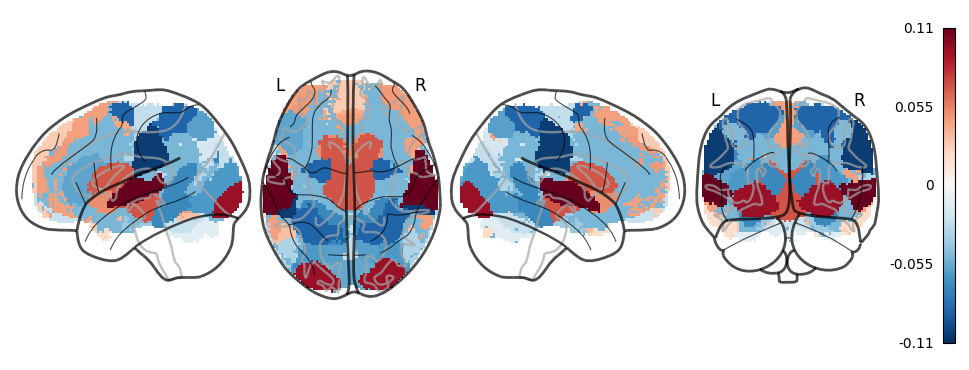

In [131]:
from nilearn.plotting import plot_glass_brain

ROI_corr_cmk_brain = roi_to_brain(ROI_corr, mask_x)
plot_glass_brain(ROI_corr_cmk_brain.to_nifti(), display_mode='lzry',colorbar=True,cmap='RdBu_r',plot_abs=False)


#### Brain data: Media; Behavioral data: cmk (postscan_child_survey)

In [128]:
partitipants_neural_all = Brain_Data()
for subject in sub_name_all_neural_similarity:
    partitipants_neural_all = partitipants_neural_all.append(Brain_Data(glob.glob(os.path.join(base_dir,'denoised','unsmoothed','beta',f'{subject}*{condition[2]}*.nii.gz')))-Brain_Data(glob.glob(os.path.join(base_dir,'denoised','unsmoothed','beta',f'{subject}*{condition[4]}*.nii.gz'))))

In [125]:
ROI_corr = []
for ROI in tqdm(range(50)):
    neural_corr = pd.DataFrame(partitipants_neural_all.apply_mask(mask_x[ROI]).data).T.corr()
    neural_corr = np.array(neural_corr)
    neural_corr_trail = neural_corr[np.triu_indices(34, 1)]
    neural_distance = 1-neural_corr_trail

    cmk_distance_trail = cmk_distance[np.triu_indices(34, 1)]

    data_pd = pd.DataFrame(np.array([neural_distance,cmk_distance_trail]).T,columns = ['neural','behavior'])
    results_corr = data_pd.corr(method = 'spearman').iloc[0,1]
    ROI_corr.append(results_corr)

  0%|          | 0/50 [00:00<?, ?it/s]

/Users/menghanyang/anaconda3/envs/py39/lib/python3.9/site-packages/nilearn/masking.py:974: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)
/Users/menghanyang/anaconda3/envs/py39/lib/python3.9/site-packages/nilearn/masking.py:974: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)
/Users/menghanyang/anaconda3/envs/py39/lib/python3.9/site-packages/nilearn/masking.py:974: UserWarning: Data array used to create a new imag

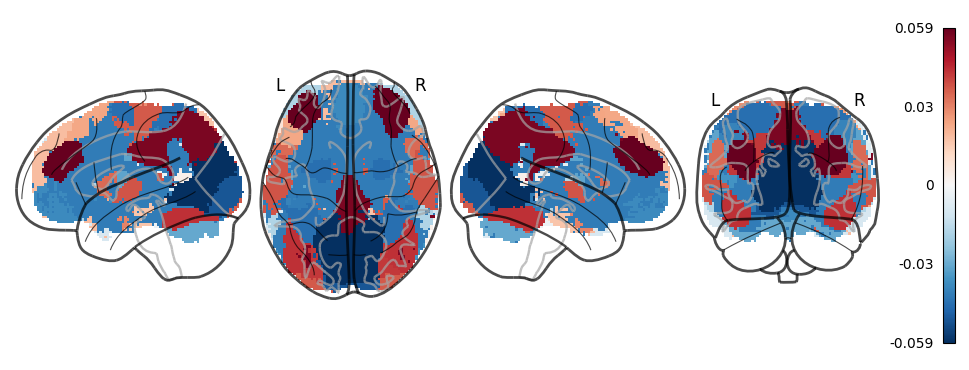

In [127]:
from nilearn.plotting import plot_glass_brain

ROI_corr_cmk_brain = roi_to_brain(ROI_corr, mask_x)
plot_glass_brain(ROI_corr_cmk_brain.to_nifti(), display_mode='lzry',colorbar=True,cmap='RdBu_r',plot_abs=False)


#### cmk

In [132]:
cmk_cols

['cmk_tv_freq',
 'cmk_tv_time',
 'cmk_dvd_freq',
 'cmk_dvd_time',
 'cmk_youtik_freq',
 'cmk_youtik_time',
 'cmk_insta_freq',
 'cmk_insta_time',
 'cmk_discord_freq',
 'cmk_discord_time',
 'cmk_mine_freq',
 'cmk_mine_time',
 'cmk_text_freq',
 'cmk_text_time',
 'cmk_like_youtube',
 'cmk_like_tik',
 'cmk_like_insta',
 'cmk_like_snap',
 'cmk_like_discord',
 'cmk_like_roblox',
 'cmk_like_mine',
 'cmk_like_messenger',
 'cmk_like_messenger_2']

##### 1.pvalue (IS-RSA)
##### 2.separating items